In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Creating a mock catalogue with Galaxia**
Galaxia needs an input parameter file which I have prepared in the input folder. It will sample 10% of the stars with an apparent V magnitude brighter than 11th mag (without extinction). Have a look at the file and compare with the Galaxia instructions [http://galaxia.sourceforge.net/Galaxia3pub.html].

In [2]:
import subprocess
## Running galaxia in the command line. This will take some time (ca. 10min).
filename = 'TGAS_11Vmag.ebf'

In [3]:


# Creating mock catalogue
args = ['galaxia', '-r', '../input/myparameterfile']
p = subprocess.Popen(args, stdout=subprocess.PIPE, stderr=subprocess.PIPE)	
print("Galaxia spawns catalogue")
(output, err) = p.communicate()
#p_status = p.wait()
print(output)

Galaxia spawns catalogue
CODEDATAPATH=/home/jan/GalaxiaData/
Reading Parameter file-             ../input/myparameterfile
--------------------------------------------------------
outputFile               TGAS_11Vmag             
outputDir                ./../output             
photoSys                 UBV                     
magcolorNames            V,B-V                   
appMagLimits[0]          -1000                   
appMagLimits[1]          11                      
absMagLimits[0]          -1000                   
absMagLimits[1]          1000                    
colorLimits[0]           -1000                   
colorLimits[1]           1000                    
geometryOption           0                       
longitude                0                       
latitude                 90                      
surveyArea               1000                    
fSample                  0.1                     
popID                    -1                      
warpFlareOn          

You can add other photometric systems using 

```
galaxia -a --psys=photometricSystem galaxy1.ebf
```
for photometric system you can use SDSS, UBV or Gaia which are in the Galaxia isochrones folder. Though for Gaia you will have to download tables from [http://stev.oapd.inaf.it/cgi-bin/cmd] where you can also update the existing ones. Maybe Morgan [https://github.com/mfouesneau] can help with automatic query of that website. You can also ask me (rybizki@mpia.de) and I can provide you with ready made Isochrone folders for Galaxia.

In [4]:
# Adding other photometric bands
args = ['galaxia', '-a', '--psys=Gaia' ,'../output/' + filename]
p = subprocess.Popen(args, stdout=subprocess.PIPE, stderr=subprocess.PIPE)	
print("Galaxia adds Gaia bands")
(output, err) = p.communicate()
#p_status = p.wait()
print(output)


Galaxia adds Gaia bands
CODEDATAPATH=/home/jan/GalaxiaData/
Reading tabulated values from file- /home/jan/GalaxiaData/Model/vcirc.dat
Calulating magnitudes................
Reading Isochrones from dir-        /home/jan/GalaxiaData/Isochrones/padova/Gaia
Isochrone Grid Size:                (Age bins=176,Feh bins=34,Alpha bins=1)
Time Isochrone Reading              9.14779     
Skipping /teff /lum /grav
Skipping /mact /mtip
Total Time=                         9.26562     



In [5]:
# Adding other photometric bands
args = ['galaxia', '-a', '--psys=SDSS' ,'../output/' + filename]
p = subprocess.Popen(args, stdout=subprocess.PIPE, stderr=subprocess.PIPE)	
print("Galaxia adds SDSS bands")
(output, err) = p.communicate()
#p_status = p.wait()
print(output)

Galaxia adds SDSS bands
CODEDATAPATH=/home/jan/GalaxiaData/
Reading tabulated values from file- /home/jan/GalaxiaData/Model/vcirc.dat
Calulating magnitudes................
Reading Isochrones from dir-        /home/jan/GalaxiaData/Isochrones/padova/SDSS
Isochrone Grid Size:                (Age bins=176,Feh bins=34,Alpha bins=1)
Time Isochrone Reading              9.34912     
Skipping /teff /lum /grav
Skipping /mact /mtip
Total Time=                         9.50603     



In [6]:
# Now we want to convert the ebf file to numpy files
import ebf
import os
import sys
path = os.path.abspath('../library/')
if path not in sys.path:
    sys.path.append(path)

In [7]:
from convert_to_recarray import convert
# Reading in the Catalogue and converting it to npy file. (If you added photometric bands then you will have to edit the convert routine)

filename = 'TGAS_11Vmag.ebf'

bes = ebf.read('../output/' + filename,'/')
x = convert(bes)
print(len(x))
print(x.dtype.names)

193657
('rad', 'exbv_solar', 'teff', 'mag2', 'mag1', 'mag0', 'satid', 'vx', 'vy', 'vz', 'mtip', 'pz', 'px', 'py', 'feh', 'exbv_schlegel', 'lum', 'exbv_schlegel_inf', 'mact', 'glon', 'popid', 'glat', 'alpha', 'smass', 'ubv_r', 'ubv_u', 'partid', 'ubv_v', 'age', 'grav', 'ubv_b', 'ubv_i', 'ubv_h', 'ubv_k', 'ubv_j', 'fieldid', 'sdss_u', 'sdss_g', 'sdss_r', 'sdss_i', 'sdss_z', 'gaia_g', 'gaia_g_bp', 'gaia_g_rp')


In [8]:
# We add ra and dec

from astropy.coordinates import SkyCoord
from astropy import units as u
from numpy.lib.recfunctions import append_fields

x = append_fields(x,('ra','dec'),(np.zeros(len(x)),np.zeros(len(x))),usemask=False)
c = SkyCoord(b=x['glat'], l=x['glon'], frame = 'galactic', unit=(u.deg, u.deg))
x['ra'] = c.icrs.ra.deg
x['dec'] = c.icrs.dec.deg

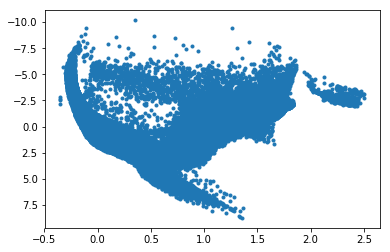

In [9]:
plt.plot(x['ubv_b']-x['ubv_v'], x['ubv_v'],'.')
plt.gca().invert_yaxis()

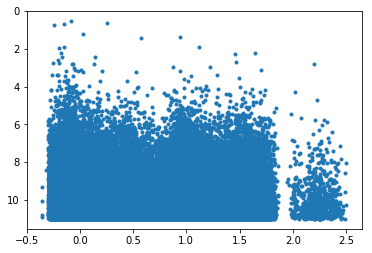

In [10]:
## Turning absolute into apparent magnitudes

filternames = ['ubv_u','ubv_b','ubv_v','ubv_r','ubv_i','ubv_j','ubv_h','ubv_k','sdss_u','sdss_g','sdss_r','sdss_i','sdss_z','gaia_g','gaia_g_bp','gaia_g_rp']	
for band in filternames:
    x[band] += 5 * np.log10(x['rad']*1000.) - 5

plt.plot(x['ubv_b']-x['ubv_v'], x['ubv_v'],'.')
plt.gca().invert_yaxis()

In [11]:
## Optional you can use extinctions from Bovy 2016 python package mwdust (using Green2015, Marshall2006 and Schlegel)
'''
from make_bovy_extinction import apply_bovy_extinction
x = apply_bovy_extinction(x)
'''

'\nfrom make_bovy_extinction import apply_bovy_extinction\nx = apply_bovy_extinction(x)\n'

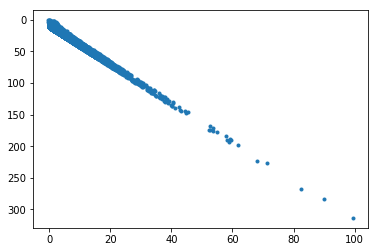

In [12]:
# Adding extinctions on top

## Adding extinction to apparent magnitudes
## Gaia extinction
Av = x['exbv_schlegel'] * 2.742
vmi = x['ubv_v'] - x['ubv_i']
gaia_g_ext = Av * (0.95 - 0.1569 * vmi + 0.021 * vmi*vmi - 0.001 * vmi*vmi*vmi) # from Jordi+ 2010
x['gaia_g'] += gaia_g_ext
gaia_g_bp_ext = x['exbv_schlegel'] * 2.8 # from Jordi+ 2010 and Schlafly + Finkbeiner 2011 closest effective wavelength
x['gaia_g_bp'] += gaia_g_bp_ext 
gaia_g_rp_ext = x['exbv_schlegel'] * 1.52 # from Jordi+ 2010 and Schlafly + Finkbeiner 2011 closest effective wavelength
x['gaia_g_rp'] += gaia_g_rp_ext

## Other bands
filternames = ['ubv_u','ubv_b','ubv_v','ubv_r','ubv_i','ubv_j','ubv_h','ubv_k','sdss_u','sdss_g','sdss_r','sdss_i','sdss_z']#,'gaia_g','gaia_g_bp','gaia_g_rp']	
extinction_coefficients = [4.334, 3.626, 2.742, 2.169, 1.505, 0.709, 0.449, 0.302, 4.239, 3.303, 2.285, 1.698, 1.263] #List from Schlafly & Finkbeiner 2011
for i,band in enumerate(filternames):
    x[band] += x['exbv_schlegel'] * extinction_coefficients[i]
plt.plot(x['ubv_b']-x['ubv_v'], x['ubv_v'],'.')
plt.gca().invert_yaxis()

193657
104194


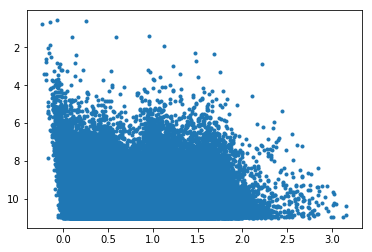

In [13]:
# Now create a mag limited sample roughly half of the sample will be lost due to extinction

print(len(x))
cut = (x['ubv_v']<11.0)
x = x[cut]
print(len(x))

plt.plot(x['ubv_b']-x['ubv_v'], x['ubv_v'],'.')
plt.gca().invert_yaxis()

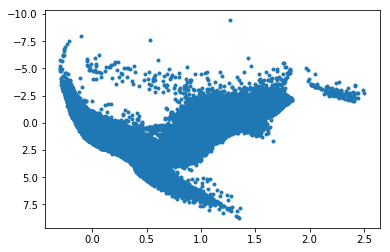

In [14]:
# Converting back into absolute magnitudes

v_abs = x['ubv_v'] - 5 * np.log10(x['rad']*1000.) + 5 - x['exbv_schlegel'] * 2.742 
b_abs = x['ubv_b'] - 5 * np.log10(x['rad']*1000.) + 5 - x['exbv_schlegel'] * 3.626 
plt.plot(b_abs-v_abs, v_abs,'.')
plt.gca().invert_yaxis()

In [15]:
# Adding parallaxes and errors
x = append_fields(x, 'parallax', (np.zeros(len(x))), usemask = False)
x = append_fields(x, 'fractional_parallax_error', (np.zeros(len(x))), usemask = False)
z = np.max((np.power(10,np.ones(len(x))*0.4*(12.09-15.)),np.power(10,0.4*(x['gaia_g']-15.))), axis = 0)
sigma = np.sqrt(-1.631+680.766*z+32.732*z*z) * (0.986+(1-0.986)*(x['ubv_v']-x['ubv_i']))
p_error = np.divide(sigma,1000.)
x['parallax'] = np.divide(1000,x['rad']*1000.)
x['fractional_parallax_error'] = np.divide(p_error,x['parallax'])
print("adding parallax error")

adding parallax error


In [16]:
np.save('../output/' + filename[:-4],x)

# save it as fits to inspect this in topcat
#from astropy.io import fits
#fits.writeto('TGAS_11mag.fits',x)

total number of stars = 1041940
3.72336557341
1041940.0
77590.4705112


/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:1403: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


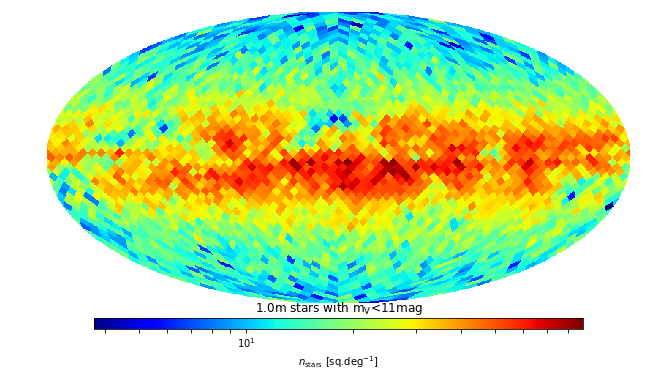

In [17]:
### Plot the stellar density across the sky
## Using plotting routines from Tri Astraatmadja
import healpy as hp
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import matplotlib
from defaults import getLogTickMarks


x = np.load('../output/' + filename[:-4] + '.npy')
NSIDE = 16
oversampling = 10
total = len(x)
x['glon'] = x['glon'] * (np.pi/180.)
x['glat'] = (90.-x['glat']) * (np.pi/180.)
print 'total number of stars = %.d' %(total * oversampling)
count = hp.ang2pix(NSIDE,x['glat'],x['glon'])
sqdegs = 41253
pixels = NSIDE * NSIDE * 12
pixel_per_sqdeg = pixels / float(sqdegs)
min_density = oversampling * pixel_per_sqdeg 
m = np.arange(hp.nside2npix(NSIDE))
density = np.zeros(hp.nside2npix(NSIDE))
for item in count:
    density[item] += oversampling * pixel_per_sqdeg
print np.min(density)
print sum(density)/pixel_per_sqdeg
print sum(density)
cmap = cm.jet
cmap.set_under(cmap(0.0))
cmap.set_over(cmap(1.0))
norm=LogNorm()
minVal = np.nanmin(density[density>0])
maxVal = np.nanmax(density[density<+np.inf])
density[density<minVal] = minVal
x['glon'] = x['glon'] * (180./np.pi)
cbLabel=r'$n_{\rm stars}$ [sq.deg$^{-1}$]'
hp.mollview(density, unit=cbLabel, min=minVal, max=maxVal, nest=False, title='', norm=norm, cmap=cmap, cbar=None)
fig = plt.gcf()
ax = plt.gca()
pos1 = ax.get_position() # get the original position 
pos2 = [pos1.x0, pos1.y0 + 0.06,  pos1.width, pos1.height]
ax.set_position(pos2) # set a new position
im = ax.get_images()[0]
cbAx = fig.add_axes([0.1, 0.12, 0.8, 0.03])
cb = plt.colorbar(im, cax=cbAx, orientation='horizontal', )
cb.ax.minorticks_on()
tickMarks = getLogTickMarks(minVal, maxVal)
minorticks = im.norm(tickMarks)
cb.ax.xaxis.set_ticks(minorticks, minor=True)
cb.solids.set_edgecolor("face")
cb.set_label(cbLabel)
plt.title(r"%.1fm stars with m$_\mathrm{V}$<11mag" %(total*oversampling/1e6), fontsize = 12)
plt.show()